<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

% matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0) # set default chart size for notebook

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [3]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

In [4]:
# check shape of X and y
print('Shape of X: {} and y: {}'.format(X.shape, y.shape))

Shape of X: (506, 13) and y: (506, 1)


In [5]:
# Check summary stats for features
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [6]:
# Check data types / counts of features
# no missing data, everything is a float
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [7]:
# Check summary stats for target
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [8]:
# Check data type / counts of target
# no missing values
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
MEDV    506 non-null float64
dtypes: float64(1)
memory usage: 4.0 KB


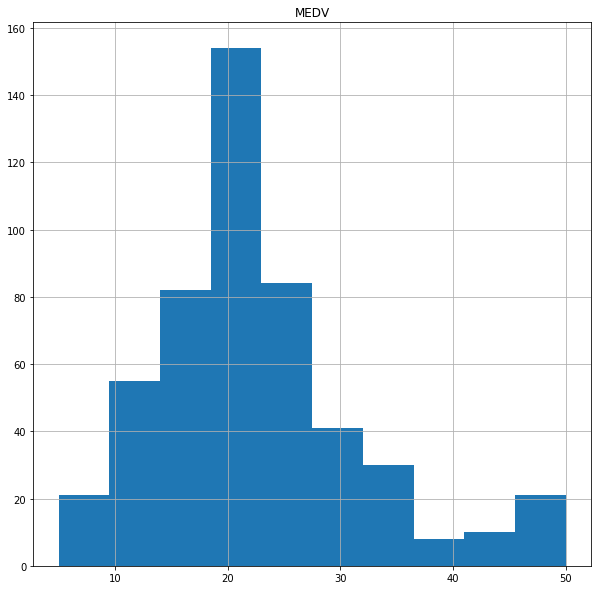

In [9]:
# Check distribution of target variable: MEDV
# weird right tail at 50
y.hist(figsize=(10,10));

In [10]:
# Unique counts of values - check a few features
X.CHAS.value_counts()

0.0    471
1.0     35
Name: CHAS, dtype: int64

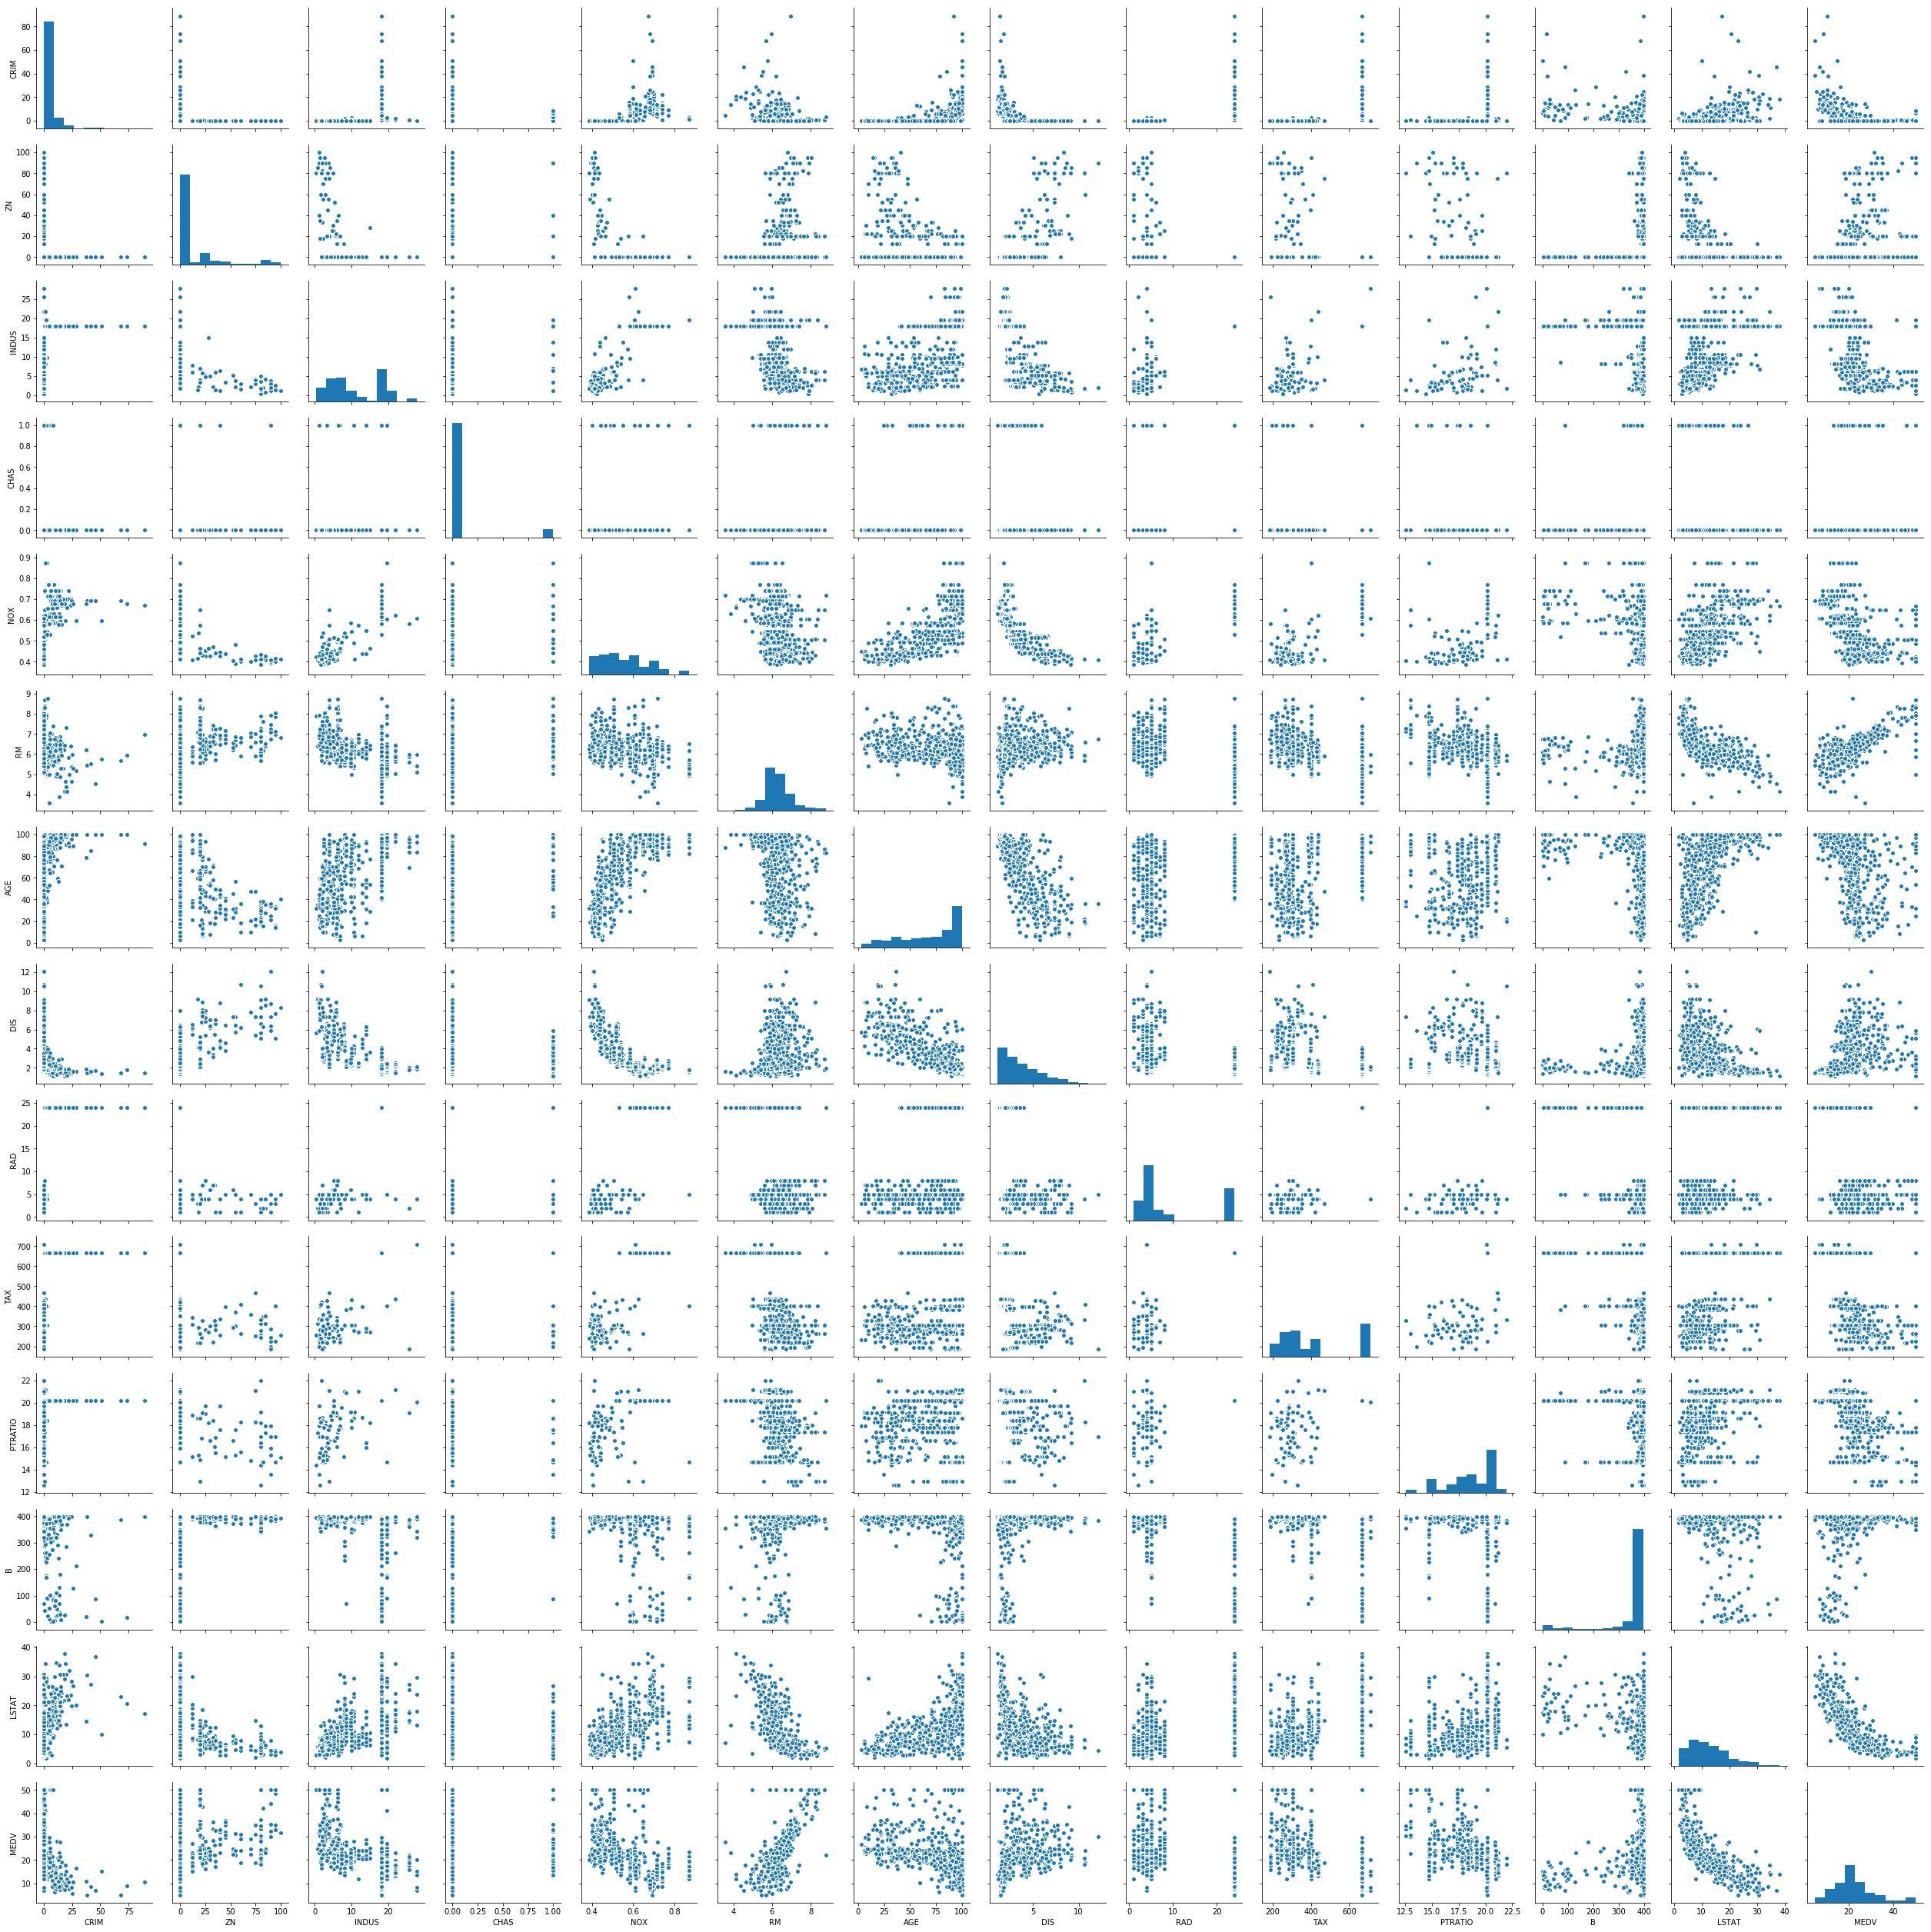

In [11]:
# look a relationships between features and target
sns.pairplot(X.merge(y, left_index=True, right_index=True));

Notes:
- The `RM` and `LSTAT` variables appear to have the strongest linear-ish relationship to our target `MEDV`
- There is a clear relationship between `RM` and `LSTAT`
- There is a clear relationship between `DIS` and `NOX`

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [12]:
# import sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [13]:
# create function to run model and create some scoring
def lin_reg(X, y, test_size, features):
    
    # split data into training + testing 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123)
    
    # instantiate the model
    lr = LinearRegression()
    
    # fit the model
    lr.fit(X_train[features],y_train)
    
    # get fitted values for training set
    #y_fitted = lr.predict(X_train[features])

    # get predictions for test set
    y_pred = lr.predict(X_test[features])
    
    # get null model predictions
    y_null = [y_train.mean() for x in range(len(y_test))]
    
    # print results
    print('Training R^2 Score: {:.2f}'.format(lr.score(X_train[features], y_train)))
    print('Test R^2 Score: {:.2f}'.format(lr.score(X_test[features], y_test)))
    print('')
    #print('Training MSE: {:.2f} - Does this matter?'.format(mean_squared_error(y_train, y_fitted)))
    print('Test MSE: {:.2f}'.format(mean_squared_error(y_test, y_pred)))
    print('Null MSE: {:.2f}'.format(mean_squared_error(y_test, y_null)))
    
    return(y_test, y_pred)

In [14]:
# create function to plot actuals vs predictions with corr info
def plot_actuals_vs_predictions(y, y_pred):
    corr = stats.pearsonr(y, y_pred)

    plt.figure(figsize=(10,10))
    plt.scatter(y, y_pred, label='actual vs predicted')
    plt.scatter(y, y, label='actual vs actual, for reference')
    plt.title('Compare y_actual and y_pred \n corr coef: {:.3f}, p: {:.5f}'.format(corr[0][0], corr[1][0]), fontsize=14)
    plt.legend()
    plt.xlabel('y_actual', fontsize=12)
    plt.ylabel('y_pred', fontsize=12);

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [15]:
# pick features
features = ['LSTAT','RM','TAX']

#### Run 70/30 model

In [16]:
y_test_30, y_pred_30  = lin_reg(X, y, 0.3, features)

Training R^2 Score: 0.69
Test R^2 Score: 0.52

Test MSE: 38.64
Null MSE: 81.41


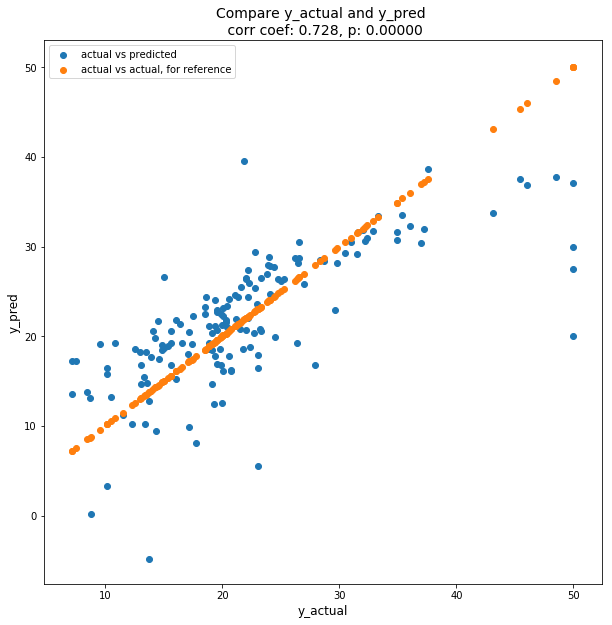

In [17]:
plot_actuals_vs_predictions(y_test_30, y_pred_30)

#### Run 90/10 model

In [18]:
y_test_10, y_pred_10  = lin_reg(X, y, 0.1, features)

Training R^2 Score: 0.67
Test R^2 Score: 0.49

Test MSE: 58.41
Null MSE: 122.36


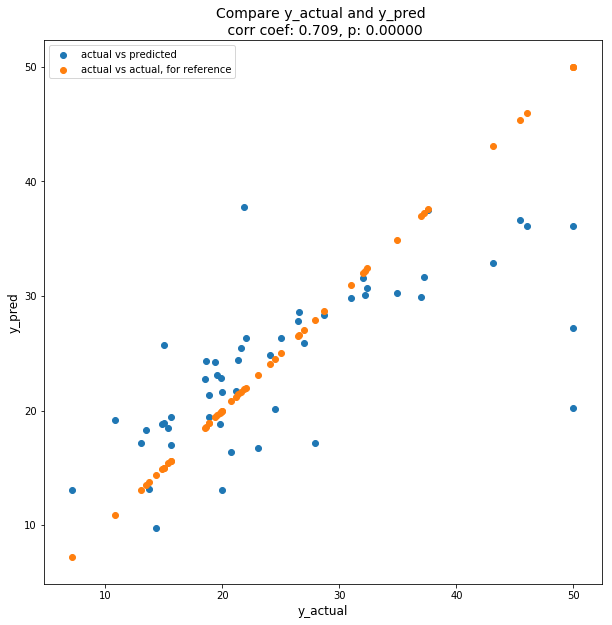

In [19]:
plot_actuals_vs_predictions(y_test_10, y_pred_10)

#### Summary
- Both models appear to be overfitting (Much higher scores for training sets vs test)
- The 70/30 model performed better than 90/10 
- The smaller test set (only 10%) is definitely not sufficient to prevent over-fitting with the selected features

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [20]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# iterate through folds 5-10
for folds in range(5,11):
    print('------------------------------------\n')
    print('K: {}'.format(folds))
    model = LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, X[features], y, cv=folds)
    print("Cross-validated scores: {}".format([score.astype(str)[:4] for score in scores]))
    print("Mean CV R^2: {:.3f}".format(np.mean(scores)))
    print('Std CV R^2: {:.3f}'.format(np.std(scores)))
    
    # Make cross-validated predictions
    predictions = cross_val_predict(model, X[features], y, cv=folds)
    
    r2 = metrics.r2_score(y, predictions)
    print("Cross-Predicted R^2: {:.3f}".format(r2))
    
    # Get MSE
    mse = mean_squared_error(y, predictions)
    print('MSE: {:.3f}'.format(mse))

------------------------------------

K: 5
Cross-validated scores: ['0.58', '0.70', '0.43', '0.00', '-0.3']
Mean CV R^2: 0.286
Std CV R^2: 0.377
Cross-Predicted R^2: 0.508
MSE: 41.536
------------------------------------

K: 6
Cross-validated scores: ['0.54', '0.69', '0.52', '0.62', '-0.2', '-0.1']
Mean CV R^2: 0.341
Std CV R^2: 0.369
Cross-Predicted R^2: 0.503
MSE: 41.977
------------------------------------

K: 7
Cross-validated scores: ['0.59', '0.61', '0.53', '0.50', '0.20', '-0.3', '0.14']
Mean CV R^2: 0.323
Std CV R^2: 0.322
Cross-Predicted R^2: 0.490
MSE: 43.016
------------------------------------

K: 8
Cross-validated scores: ['0.61', '0.62', '0.68', '0.61', '0.60', '-0.5', '-0.9', '0.13']
Mean CV R^2: 0.223
Std CV R^2: 0.596
Cross-Predicted R^2: 0.558
MSE: 37.272
------------------------------------

K: 9
Cross-validated scores: ['0.64', '0.57', '0.68', '0.46', '0.58', '0.58', '-0.2', '-1.1', '0.14']
Mean CV R^2: 0.246
Std CV R^2: 0.583
Cross-Predicted R^2: 0.534
MSE: 39.325


#### Summary
The cross-validated scores seem to vary a lot between folds
- For each iteration of n, we see some negative scores
- As folds increase beyond 7 the STD of R^2 increases - indicates more variation

These cross validation methods don't shuffle or randomly split the data

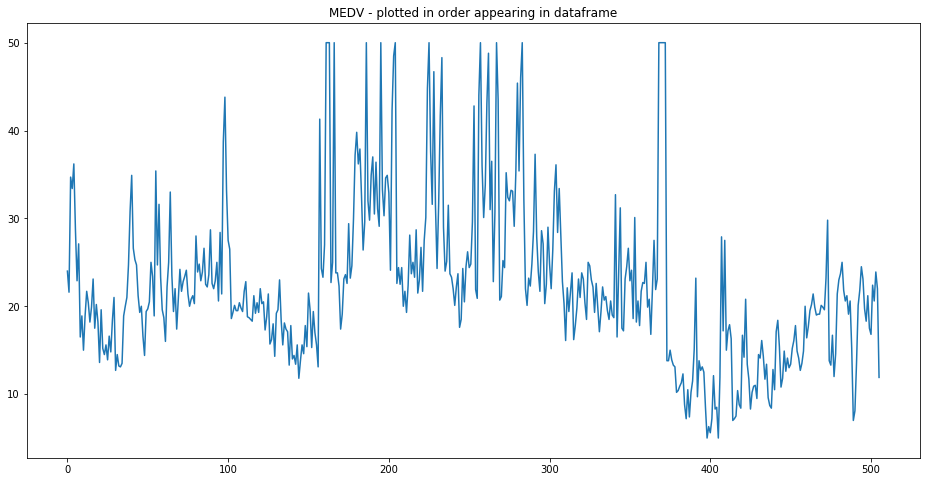

In [22]:
# The MEDV target plotted by index
# looks like the average value varies depending on the fold (folds are not random by default)
# This means that the target values in each fold are very different
plt.plot(y)
plt.title('MEDV - plotted in order appearing in dataframe');

In [23]:
# try this again, shuffling the df first
df = X.join(y)

df_shuffled = df.sample(frac=1).reset_index(drop=True)
X_shuffled = df_shuffled[features]
y_shuffled = df_shuffled['MEDV']

# iterate through folds 5-10
for folds in range(5,11):
    print('------------------------------------\n')
    print('K: {}'.format(folds))
    model = LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, X_shuffled, y_shuffled, cv=folds)
    print("Cross-validated scores: {}".format([score.astype(str)[:4] for score in scores]))
    print("Mean CV R^2: {:.3f}".format(np.mean(scores)))
    print('Std CV R^2: {:.3f}'.format(np.std(scores)))
    
    # Make cross-validated predictions
    predictions = cross_val_predict(model, X[features], y, cv=folds)
    
    r2 = metrics.r2_score(y, predictions)
    print("Cross-Predicted R^2: {:.3f}".format(r2))
    
    # Get MSE
    mse = mean_squared_error(y, predictions)
    print('MSE: {:.3f}'.format(mse))

------------------------------------

K: 5
Cross-validated scores: ['0.74', '0.50', '0.56', '0.65', '0.67']
Mean CV R^2: 0.630
Std CV R^2: 0.083
Cross-Predicted R^2: 0.508
MSE: 41.536
------------------------------------

K: 6
Cross-validated scores: ['0.76', '0.55', '0.63', '0.53', '0.60', '0.68']
Mean CV R^2: 0.630
Std CV R^2: 0.078
Cross-Predicted R^2: 0.503
MSE: 41.977
------------------------------------

K: 7
Cross-validated scores: ['0.76', '0.68', '0.41', '0.56', '0.72', '0.45', '0.70']
Mean CV R^2: 0.618
Std CV R^2: 0.131
Cross-Predicted R^2: 0.490
MSE: 43.016
------------------------------------

K: 8
Cross-validated scores: ['0.77', '0.66', '0.54', '0.67', '0.49', '0.65', '0.44', '0.73']
Mean CV R^2: 0.623
Std CV R^2: 0.109
Cross-Predicted R^2: 0.558
MSE: 37.272
------------------------------------

K: 9
Cross-validated scores: ['0.74', '0.71', '0.56', '0.49', '0.56', '0.67', '0.62', '0.43', '0.72']
Mean CV R^2: 0.616
Std CV R^2: 0.103
Cross-Predicted R^2: 0.534
MSE: 39.325


#### Summary
- No more negative cross validated R^2 values

8-folds appears to perform the best:
- Lowest MSE
- Highest cross-predicted R^2

# KNN Practice

In [24]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [25]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

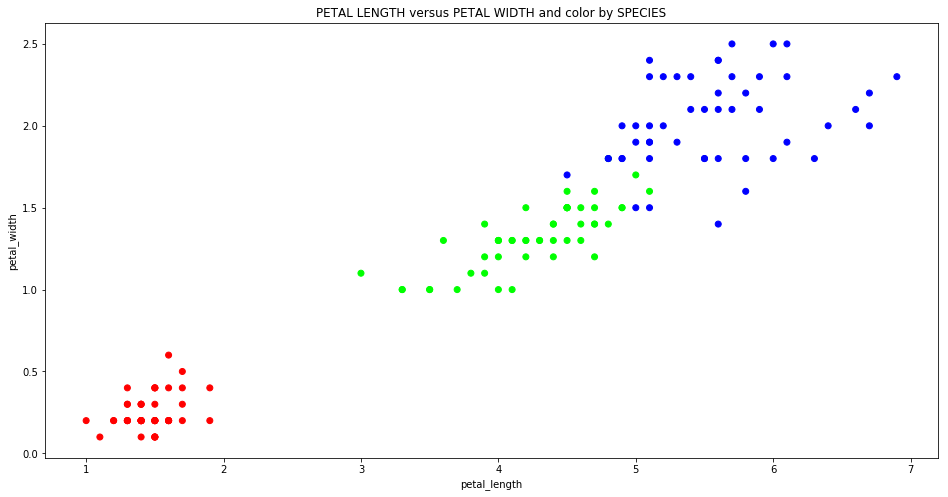

In [26]:
# Map each iris species to a number
# Let's use 'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = iris['species'].replace({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
plt.scatter(iris.petal_length, iris.petal_width, c=iris.species_num, cmap=cmap_bold)
plt.title('PETAL LENGTH versus PETAL WIDTH and color by SPECIES')
plt.xlabel('petal_length')
plt.ylabel('petal_width');

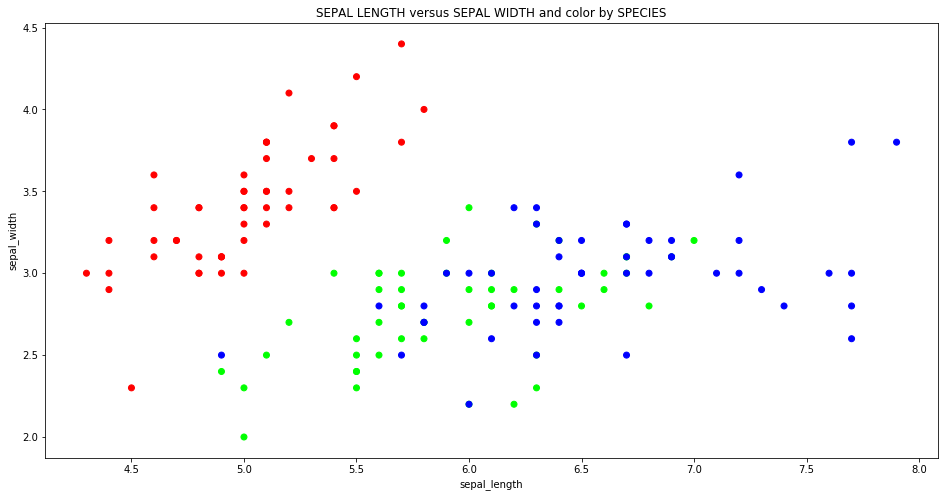

In [27]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
plt.scatter(iris.sepal_length, iris.sepal_width, c=iris.species_num, cmap=cmap_bold)
plt.title('SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [28]:
# get X by keeping any columns that don't start with 'species'
cols = list(iris.columns)
keep_cols = [col for col in cols if not col.startswith('species')]
X = iris[keep_cols]
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Create your target vector "y"
This will be the species type.

In [29]:
y = iris['species_num']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: species_num, dtype: int64

### Instructions:
- Make Use of Train-Test-Split
    - Split your data in to train and test sets.
- Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor
- Check the Accuracy
    - Train your model using the training set then use the test set to determine the accuracy

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
# Create functions to run model and print scores
def knn(X, y, n, test_size):
    
    # fit the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123)

    # instantiate the classifider and specify # of neighors 
    knn = KNeighborsClassifier(n_neighbors=n)

    # fit the model on training data
    knn.fit(X_train, y_train)

    # get fitted values for training set
    y_fitted = knn.predict(X_train)

    # get predictions for test set
    y_pred = knn.predict(X_test)

    # get null model predictions
    y_null = [y_train.value_counts().index[0] for x in range(len(y_test))]

    # print results
    print('Training Accuracy Score: {:.2f}'.format(knn.score(X_train, y_train)))
    print('Test Accuracy Score: {:.2f}'.format(knn.score(X_test, y_test)))

In [32]:
knn(X, y, n=1, test_size=.25)

Training Accuracy Score: 1.00
Test Accuracy Score: 0.89


### Create a Model With Five Neighbors. Did it Improve?

In [33]:
# increasing n to 5 improved the test accuracy from .89 to .97
knn(X, y, n=5, test_size=.25)

Training Accuracy Score: 0.98
Test Accuracy Score: 0.97


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [39]:
def knn_loop(X, y, n_neighbors):
    for n in range(1,n_neighbors+1):
        print('N = {}'.format(n))
        knn(X, y, n=n, test_size=.25)
        print('----------------------------- \n')

In [41]:
# n = 5 still looks the best
knn_loop(X,y,5)

N = 1
Training Accuracy Score: 1.00
Test Accuracy Score: 0.89
----------------------------- 

N = 2
Training Accuracy Score: 0.99
Test Accuracy Score: 0.89
----------------------------- 

N = 3
Training Accuracy Score: 0.98
Test Accuracy Score: 0.95
----------------------------- 

N = 4
Training Accuracy Score: 0.98
Test Accuracy Score: 0.95
----------------------------- 

N = 5
Training Accuracy Score: 0.98
Test Accuracy Score: 0.97
----------------------------- 



### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [42]:
help(KNeighborsClassifier.predict_proba)

Help on function predict_proba in module sklearn.neighbors.classification:

predict_proba(self, X)
    Return probability estimates for the test data X.
    
    Parameters
    ----------
    X : array-like, shape (n_query, n_features),                 or (n_query, n_indexed) if metric == 'precomputed'
        Test samples.
    
    Returns
    -------
    p : array of shape = [n_samples, n_classes], or a list of n_outputs
        of such arrays if n_outputs > 1.
        The class probabilities of the input samples. Classes are ordered
        by lexicographic order.



#### Summary
The `predit_proba()` method will return an array with the probability that each observation will fall into each possible class

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [43]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [44]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}


model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Mon, 08 Oct 2018   Prob (F-statistic):          1.59e-321
Time:                        11:01:21   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# see each case
for f in formulas:
    print('############################################################################## \n')
    print('MODEL USING VARIABLES FROM: {} \n'.format(f.upper()))
    model = smf.ols(formula=formulas[f], data=df)
    result = model.fit()
    print(result.summary())
    print('\n')

############################################################################## 

MODEL USING VARIABLES FROM: CASE1 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Mon, 08 Oct 2018   Prob (F-statistic):          1.59e-321
Time:                        11:01:22   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [ ]:
# WIP! Didn't have time to finish this section :(
# Use forward stepwise feature selection
    # start with single predictor that produces the lowest RMSE
    # add second predictor that again produces the lowers RMSE
    # continue through all variables until we have them in order
    # then run through each subsequent model and determine where R^2 of test vs train indicates overfitting

In [ ]:
feature_cols = [x for x in df.columns if x != 'MEDV']

X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['MEDV'])
train_df = X_train.join(y_train)

formula = 'MEDV ~'
test_rmse = 100 # temp - know that actuals will be much smaller
best_feature = ''


for feature in feature_cols:
    test_formula = formula + ' ' + feature
    
    model = smf.ols(formula=test_formula, data=train_df)
    result = model.fit()
    
    y_pred = result.predict(X_test)
    new_rmse = rmse(y_test, y_pred)

    print('{}: {:.2f}'.format(feature, new_rmse))
        

In [ ]:
# example forward selection code using R^2 to evaluate
# source: https://planspace.org/20150423-forward_selection_with_statsmodels/
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
            
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
# use the forward_selected function
model = forward_selected(df, 'MEDV')

print(model.model.formula)

print('R^2: {:.2f}'.format(model.rsquared_adj))

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

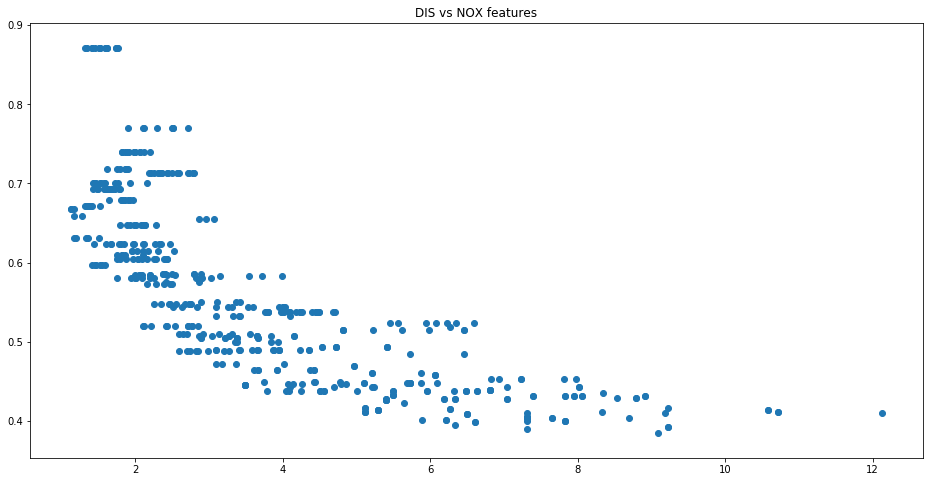

In [46]:
# Check out variable relations
# Note: Look at pairplot in EDA portion of notebook
plt.scatter(df['DIS'] , df['NOX'])
plt.title('DIS vs NOX features');

In [47]:
# Check out Pearson scores
# DIS and NOX appear to have a strong negative correlation
np.corrcoef(df['DIS'] ,df['NOX'])

array([[ 1.        , -0.76923011],
       [-0.76923011,  1.        ]])

In [48]:
# quick test to predict NOX with DIS
y_test, y_pred  = lin_reg(X=df, y=df['NOX'], test_size=0.3, features=['DIS'])

Training R^2 Score: 0.58
Test R^2 Score: 0.60

Test MSE: 0.01
Null MSE: 0.01


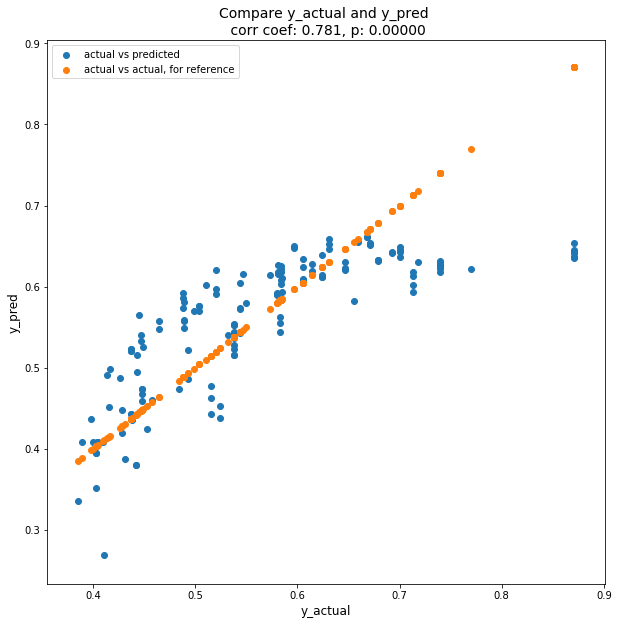

In [49]:
# plot actuals vs predictions with corr info
corr = stats.pearsonr(y_test, y_pred)

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, label='actual vs predicted')
plt.scatter(y_test, y_test, label='actual vs actual, for reference')
plt.title('Compare y_actual and y_pred \n corr coef: {:.3f}, p: {:.5f}'.format(corr[0], corr[1]), fontsize=14)
plt.legend()
plt.xlabel('y_actual', fontsize=12)
plt.ylabel('y_pred', fontsize=12);

#### Summary
- The R^2 for the test and training sets are similar - doesn't appear to be overfitting 
- Test MSE is the same as the null MSE - so this model isn't really doing much...
- There is definitely some non-linear behavior that is not being captured by the model

## Demo: Patsy

In [50]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [51]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)


In [52]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: -0.026551725454025288
